In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *
import random
from models import *
import models

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# general parameters
dataset_name = "Tree_Cycle"

model_type = Tree_Cycle_GCN
load_pretrained = True

# hyperparameters
k = 15

# other parameters
train_test_split = 0.8
num_hidden_units = 50
num_classes = 2

epochs = 22000
lr = 0.001

In [3]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split, if_adj=True)
model = model_type(data["x"].shape[1], num_hidden_units, num_classes, "Tree-Cycle")

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
    
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train(model, data, epochs, lr, paths['base'])

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of classes:  871
Number of edges:  871
Loading pretrained model...


In [4]:
x = data["x"]
edges = data["edges"]
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
print(test(model, x, y, edges, train_mask))
print(test(model, x, y, edges, test_mask))

0.9597122302158273
0.9545454545454546


In [5]:
activation_list.pop('conv0')
activation_list.pop('conv1')
activation_list.pop('linear')

for layer_num, key in enumerate(activation_list):
    print(key)
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    print(activation.shape)

conv2
(871, 50)


In [6]:
# from copy import copy
# from math import sqrt
# from typing import Optional

# import torch
# from tqdm import tqdm
# import networkx as nx
# from torch_geometric.nn import MessagePassing
# from torch_geometric.data import Data
# from torch_geometric.utils import k_hop_subgraph, to_networkx

# EPS = 1e-15

# class GNNExplainer(torch.nn.Module):
#     r"""The GNN-Explainer model from the `"GNNExplainer: Generating
#     Explanations for Graph Neural Networks"
#     <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
#     structures and small subsets node features that play a crucial role in a
#     GNN’s node-predictions.

#     .. note::

#         For an example of using GNN-Explainer, see `examples/gnn_explainer.py
#         <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
#         gnn_explainer.py>`_.

#     Args:
#         model (torch.nn.Module): The GNN module to explain.
#         epochs (int, optional): The number of epochs to train.
#             (default: :obj:`100`)
#         lr (float, optional): The learning rate to apply.
#             (default: :obj:`0.01`)
#         num_hops (int, optional): The number of hops the :obj:`model` is
#             aggregating information from.
#             If set to :obj:`None`, will automatically try to detect this
#             information based on the number of
#             :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
#             layers inside :obj:`model`. (default: :obj:`None`)
#         return_type (str, optional): Denotes the type of output from
#             :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model returns
#             the logarithm of probabilities), :obj:`"prob"` (the model returns
#             probabilities) and :obj:`"raw"` (the model returns raw scores).
#             (default: :obj:`"log_prob"`)
#         log (bool, optional): If set to :obj:`False`, will not log any learning
#             progress. (default: :obj:`True`)
#     """

#     coeffs = {
#         'edge_size': 0.005,
#         'edge_reduction': 'sum',
#         'node_feat_size': 1.0,
#         'node_feat_reduction': 'mean',
#         'edge_ent': 1.0,
#         'node_feat_ent': 0.1,
#     }

#     def __init__(self, model, epochs: int = 100, lr: float = 0.01,
#                  num_hops: Optional[int] = None, return_type: str = 'log_prob',
#                  log: bool = True):
#         super(GNNExplainer, self).__init__()
#         assert return_type in ['log_prob', 'prob', 'raw']
#         self.model = model
#         self.epochs = epochs
#         self.lr = lr
#         self.__num_hops__ = num_hops
#         self.return_type = return_type
#         self.log = log

#     def __set_masks__(self, x, edge_index, init="normal"):
#         (N, F), E = x.size(), edge_index.size(1)

#         std = 0.1
#         self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

#         std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
#         self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 module.__explain__ = True
#                 module.__edge_mask__ = self.edge_mask

#     def __clear_masks__(self):
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 module.__explain__ = False
#                 module.__edge_mask__ = None
#         self.node_feat_masks = None
#         self.edge_mask = None

#     @property
#     def num_hops(self):
#         if self.__num_hops__ is not None:
#             return self.__num_hops__

#         k = 0
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 k += 1
#         return k

#     def __flow__(self):
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 return module.flow
#         return 'source_to_target'

#     def __subgraph__(self, node_idx, x, edge_index, **kwargs):
#         num_nodes, num_edges = x.size(0), edge_index.size(1)

#         subset, edge_index, mapping, edge_mask = k_hop_subgraph(
#             node_idx, self.num_hops, edge_index, relabel_nodes=True,
#             num_nodes=num_nodes, flow=self.__flow__())

#         x = x[subset]
#         for key, item in kwargs.items():
#             if torch.is_tensor(item) and item.size(0) == num_nodes:
#                 item = item[subset]
#             elif torch.is_tensor(item) and item.size(0) == num_edges:
#                 item = item[edge_mask]
#             kwargs[key] = item

#         return x, edge_index, mapping, edge_mask, kwargs

#     def __loss__(self, node_idx, log_logits, pred_label):
#         # node_idx is -1 for explaining graphs

#         loss = -log_logits[node_idx, pred_label[node_idx]] if node_idx == -1 else -log_logits[0, pred_label[0]]

#         m = self.edge_mask.sigmoid()
#         edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
#         inter = self.coeffs['edge_size'] * edge_reduce(m)
#         loss = loss + inter
#         ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
#         inter = self.coeffs['edge_ent'] * ent.mean()
#         loss = loss + inter

#         m = self.node_feat_mask.sigmoid()
#         node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
#         inter = self.coeffs['node_feat_size'] * node_feat_reduce(m)
#         loss = loss + inter
#         ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
#         inter = self.coeffs['node_feat_ent'] * ent.mean()
#         loss = loss + inter

#         return loss

#     def __to_log_prob__(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
#         x = x.log() if self.return_type == 'prob' else x
#         return x

#     def explain_graph(self, x, edge_index, **kwargs):
#         r"""Learns and returns a node feature mask and an edge mask that play a
#         crucial role to explain the prediction made by the GNN for a graph.

#         Args:
#             x (Tensor): The node feature matrix.
#             edge_index (LongTensor): The edge indices.
#             **kwargs (optional): Additional arguments passed to the GNN module.

#         :rtype: (:class:`Tensor`, :class:`Tensor`)
#         """

#         self.model.eval()
#         self.__clear_masks__()

#         # all nodes belong to same graph
#         batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

#         # Get the initial prediction.
#         with torch.no_grad():
#             out = self.model(x=x, edge_index=edge_index, batch=batch, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             pred_label = log_logits.argmax(dim=-1)

#         self.__set_masks__(x, edge_index)
#         self.to(x.device)

#         optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
#                                      lr=self.lr)

#         if self.log:  # pragma: no cover
#             pbar = tqdm(total=self.epochs)
#             pbar.set_description('Explain graph')

#         for epoch in range(1, self.epochs + 1):
#             optimizer.zero_grad()
#             h = x * self.node_feat_mask.view(1, -1).sigmoid()
#             out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             loss = self.__loss__(-1, log_logits, pred_label)
#             loss.backward()
#             optimizer.step()

#             if self.log:  # pragma: no cover
#                 pbar.update(1)

#         if self.log:  # pragma: no cover
#             pbar.close()

#         node_feat_mask = self.node_feat_mask.detach().sigmoid()
#         edge_mask = self.edge_mask.detach().sigmoid()

#         self.__clear_masks__()
#         return node_feat_mask, edge_mask

#     def explain_node(self, node_idx, x, edge_index, **kwargs):
#         r"""Learns and returns a node feature mask and an edge mask that play a
#         crucial role to explain the prediction made by the GNN for node
#         :attr:`node_idx`.

#         Args:
#             node_idx (int): The node to explain.
#             x (Tensor): The node feature matrix.
#             edge_index (LongTensor): The edge indices.
#             **kwargs (optional): Additional arguments passed to the GNN module.

#         :rtype: (:class:`Tensor`, :class:`Tensor`)
#         """

#         self.model.eval()
#         self.__clear_masks__()

#         num_edges = edge_index.size(1)

#         # Only operate on a k-hop subgraph around `node_idx`.
#         x, edge_index, mapping, hard_edge_mask, kwargs = self.__subgraph__(
#             node_idx, x, edge_index, **kwargs)

#         # Get the initial prediction.
#         with torch.no_grad():
#             transposed_edges = edge_index.transpose(0, 1)
#             if transposed_edges.shape[0] == 0:
#                 converted_adj = torch.from_numpy(np.identity(x.shape[0])).type(torch.FloatTensor)
#             else:
#                 intrim_G = nx.Graph()
#                 intermediate = transposed_edges.numpy().astype(int)
#                 for pair in intermediate:
#                     intrim_G.add_edge(pair[0], pair[1])
#                 converted_adj = nx.to_numpy_matrix(intrim_G)
#                 converted_adj = torch.from_numpy(converted_adj).type(torch.FloatTensor)

#             out = self.model(x=x, edge_index=converted_adj, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             pred_label = log_logits.argmax(dim=-1)

#         self.__set_masks__(x, edge_index)
#         self.to(x.device)

#         optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
#                                      lr=self.lr)

#         if self.log:  # pragma: no cover
#             pbar = tqdm(total=self.epochs)
#             pbar.set_description(f'Explain node {node_idx}')

#         for epoch in range(1, self.epochs + 1):
#             optimizer.zero_grad()
#             h = x * self.node_feat_mask.view(1, -1).sigmoid()

#             transposed_edges = edge_index.transpose(0, 1)
#             if transposed_edges.shape[0] == 0:
#                 converted_adj = torch.from_numpy(np.identity(h.shape[0])).type(torch.FloatTensor)
#             else:
#                 intrim_G = nx.Graph()
#                 intermediate = transposed_edges.numpy().astype(int)
#                 for pair in intermediate:
#                     intrim_G.add_edge(pair[0], pair[1])
#                 converted_adj = nx.to_numpy_matrix(intrim_G)
#                 converted_adj = torch.from_numpy(converted_adj).type(torch.FloatTensor)

#             out = self.model(x=h, edge_index=converted_adj, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             loss = self.__loss__(mapping, log_logits, pred_label)
#             loss.backward()
#             optimizer.step()

#             print(loss.item())

#             if self.log:  # pragma: no cover
#                 pbar.update(1)

#         if self.log:  # pragma: no cover
#             pbar.close()

#         node_feat_mask = self.node_feat_mask.detach().sigmoid()
#         edge_mask = self.edge_mask.new_zeros(num_edges)
#         edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

#         self.__clear_masks__()

#         return node_feat_mask, edge_mask

#     def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
#                            threshold=None, **kwargs):
#         r"""Visualizes the subgraph given an edge mask
#         :attr:`edge_mask`.

#         Args:
#             node_idx (int): The node id to explain.
#                 Set to :obj:`-1` to explain graph.
#             edge_index (LongTensor): The edge indices.
#             edge_mask (Tensor): The edge mask.
#             y (Tensor, optional): The ground-truth node-prediction labels used
#                 as node colorings. All nodes will have the same color
#                 if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
#             threshold (float, optional): Sets a threshold for visualizing
#                 important edges. If set to :obj:`None`, will visualize all
#                 edges with transparancy indicating the importance of edges.
#                 (default: :obj:`None`)
#             **kwargs (optional): Additional arguments passed to
#                 :func:`nx.draw`.

#         :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
#         """
#         import matplotlib.pyplot as plt
#         assert edge_mask.size(0) == edge_index.size(1)

#         if node_idx == -1:
#             hard_edge_mask = torch.BoolTensor([True] * edge_index.size(1),
#                                               device=edge_mask.device)
#             subset = torch.arange(edge_index.max().item() + 1,
#                                   device=edge_index.device)
#             y = None

#         else:
#             # Only operate on a k-hop subgraph around `node_idx`.
#             subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
#                 node_idx, self.num_hops, edge_index, relabel_nodes=True,
#                 num_nodes=None, flow=self.__flow__())

#         edge_mask = edge_mask[hard_edge_mask]

#         if threshold is not None:
#             edge_mask = (edge_mask >= threshold).to(torch.float)

#         if y is None:
#             y = torch.zeros(edge_index.max().item() + 1,
#                             device=edge_index.device)
#         else:
#             y = y[subset].to(torch.float) / y.max().item()

#         data = Data(edge_index=edge_index, att=edge_mask, y=y,
#                     num_nodes=y.size(0)).to('cpu')

#         G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
#         mapping = {k: i for k, i in enumerate(subset.tolist())}
#         G = nx.relabel_nodes(G, mapping)

#         node_kwargs = copy(kwargs)
#         node_kwargs['node_size'] = kwargs.get('node_size') or 800
#         node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

#         label_kwargs = copy(kwargs)
#         label_kwargs['font_size'] = kwargs.get('font_size') or 10

#         pos = nx.spring_layout(G)
#         ax = plt.gca()
#         for source, target, data in G.edges(data=True):
#             ax.annotate(
#                 '', xy=pos[target], xycoords='data', xytext=pos[source],
#                 textcoords='data', arrowprops=dict(
#                     arrowstyle="->",
#                     alpha=max(data['att'], 0.1),
#                     shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
#                     shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
#                     connectionstyle="arc3,rad=0.1",
#                 ))
#         nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
#         nx.draw_networkx_labels(G, pos, **label_kwargs)

#         return ax, G

#     def __repr__(self):
#         return f'{self.__class__.__name__}()'

In [7]:
# node_idx = 791
# # convert to edge format
# edges = data['edge_list'].t().contiguous()

# explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True, num_hops=3)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], edges)

# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=data['y'], threshold=0.1)
# plt.title(f"GNNExplainer explanation for Node {node_idx}")
# plt.axis('off')
# plt.show()

# Dimensionality Reduction

### TSNE

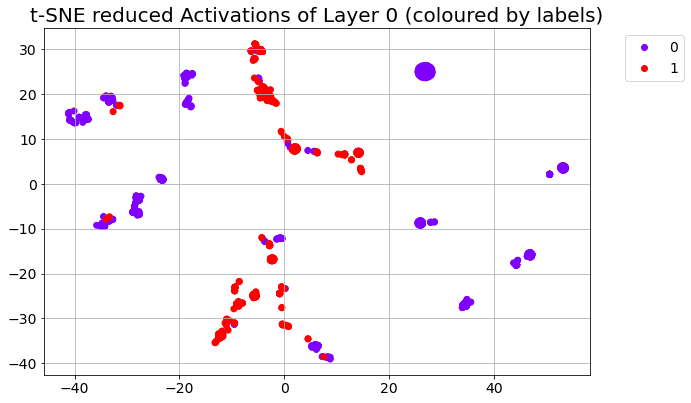

In [8]:
# TSNE conversion
tsne_models = []
tsne_data = []

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

### PCA

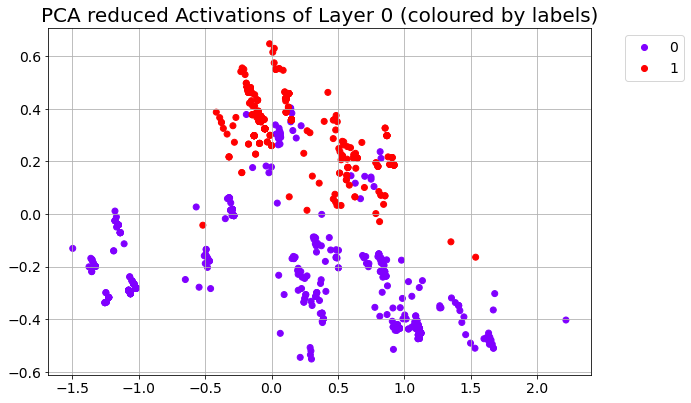

In [9]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

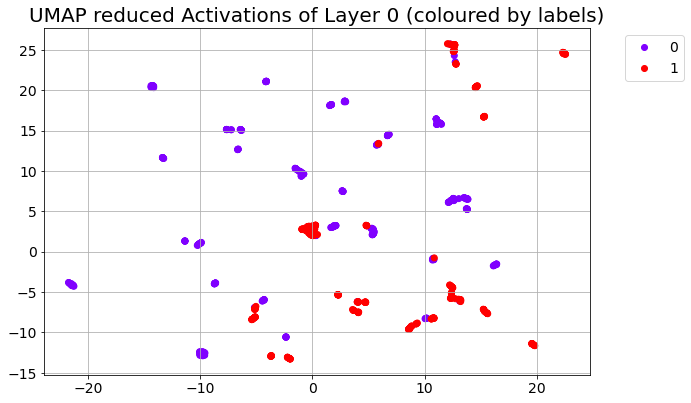

In [10]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    plot_activation_space(d, labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

In [11]:
num_nodes_view = 5
num_expansions = 4
edges = data['edge_list'].numpy()

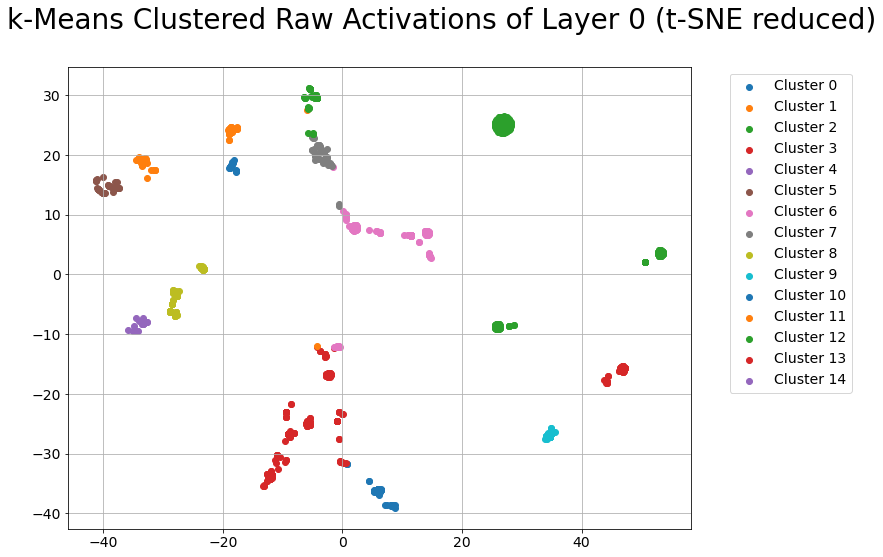

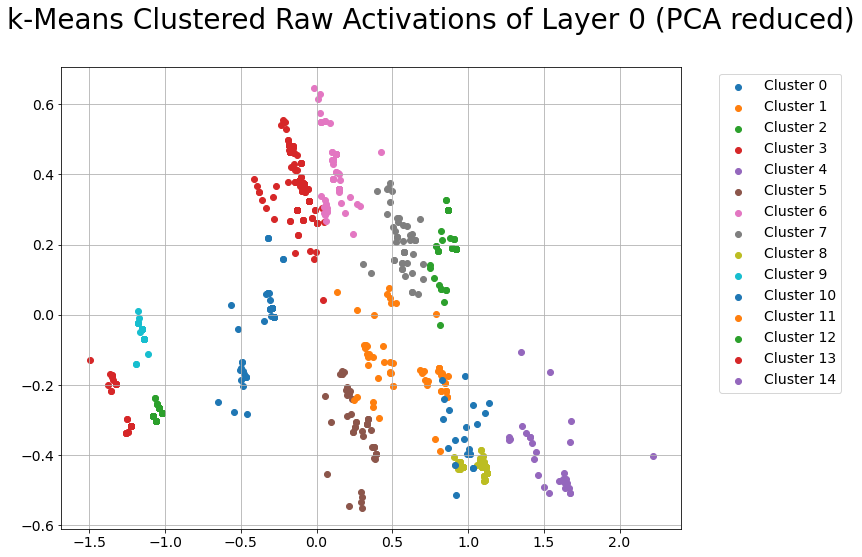

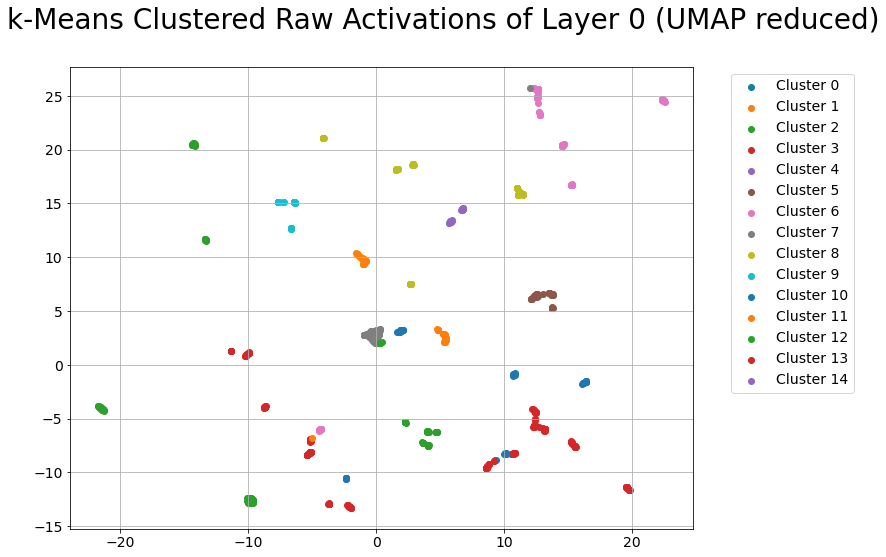

In [ ]:


raw_sample_graphs = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "Kmeans", "raw", num_nodes_view, edges, num_expansions, paths['KMeans'])

    raw_sample_graphs.append(sample_graphs)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [ ]:
# tsne_sample_graphs = []
# tsne_sample_feat = []
# tsne_kmeans_models = []
# for layer_num, item in enumerate(tsne_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     tsne_sample_graphs.append(sample_graphs)
#     tsne_sample_feat.append(sample_feat)
#     tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [ ]:
# pca_sample_graphs = []
# pca_sample_feat = []
# pca_kmeans_models = []

# for layer_num, item in enumerate(pca_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "PCA reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     pca_sample_graphs.append(sample_graphs)
#     pca_sample_feat.append(sample_feat)
#     pca_kmeans_models.append(kmeans_model)

##### UMAP

In [ ]:
# umap_sample_graphs = []
# umap_sample_feat = []
# umap_kmeans_models = []
# for layer_num, item in enumerate(umap_data):
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans_model = kmeans_model.fit(item)
#     pred_labels = kmeans_model.predict(item)

#     plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
#     sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

#     umap_sample_graphs.append(sample_graphs)
#     umap_sample_feat.append(sample_feat)
#     umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [ ]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [ ]:
# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [ ]:
# raw_n_clusters = [30, 30, 21, 3]

# raw_sample_graphs = []
# raw_sample_feat = []
# raw_ward_models = []
# for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(activation)

#     d = (activation, pred_labels)
#     plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "raw", num_nodes_view, edges, num_expansions, paths['Ward'])

#     raw_sample_graphs.append(sample_graphs)
#     raw_sample_feat.append(sample_feat)
#     raw_ward_models.append(hc)


##### TSNE

In [ ]:
# for layer_num, item in enumerate(tsne_data):
#     plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [ ]:
# tsne_n_clusters = [30, 15, 30, 30]

# tsne_sample_graphs = []
# tsne_sample_feat = []
# tsne_hc_models = []
# for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

#     tsne_sample_graphs.append(sample_graphs)
#     tsne_sample_feat.append(sample_feat)
#     tsne_hc_models.append(hc)


##### PCA

In [ ]:
# for layer_num, item in enumerate(pca_data):
#     plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [ ]:
# pca_n_clusters = [30, 4, 30, 3]

# pca_sample_graphs = []
# pca_sample_feat = []
# pca_hc_models = []
# for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "PCA reduced", num_nodes_view, edges, num_expansions, paths['HC'])

#     pca_sample_graphs.append(sample_graphs)
#     pca_sample_feat.append(sample_feat)
#     pca_hc_models.append(hc)

##### UMAP

In [ ]:
# for layer_num, item in enumerate(umap_data):
#     plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [ ]:
# umap_n_clusters = [30, 9, 30, 30]

# umap_sample_graphs = []
# umap_sample_feat = []
# umap_hc_models = []
# for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
#     pred_labels = hc.fit_predict(item)

#     d = (item, pred_labels)
#     plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

#     umap_sample_graphs.append(sample_graphs)
#     umap_sample_feat.append(sample_feat)
#     umap_hc_models.append(hc)

#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [ ]:
# num_nodes_view = 5
# num_expansions = 3
# edges = data['edge_list'].numpy()

# esp = 0.05
# min_samples = 6

# raw_sample_graphs = []
# raw_dbscan_models = []
# raw_dbscan_ds = []

# for layer_num, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(activation)
#     pred_labels = dbscan_model.fit_predict(activation)

#     num_cluster = len(np.unique(pred_labels))
#     d = (activation, pred_labels)
#     raw_dbscan_ds.append(d)

#     plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
#     plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     raw_sample_graphs.append(sample_graphs)
#     raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [ ]:
# tsne_sample_graphs = []
# tsne_dbscan_models = []
# tsne_dbscan_ds = []

# for layer_num, item in enumerate(tsne_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     tsne_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     tsne_sample_graphs.append(sample_graphs)
#     tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [ ]:
# pca_sample_graphs = []
# pca_dbscan_models = []
# pca_dbscan_ds = []

# for layer_num, item in enumerate(pca_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     pca_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     pca_sample_graphs.append(sample_graphs)
#     pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [ ]:
# umap_sample_graphs = []
# umap_dbscan_models = []
# umap_dbscan_ds = []

# for layer_num, item in enumerate(umap_data):
#     dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
#     dbscan_model = dbscan_model.fit(item)
#     pred_labels = dbscan_model.fit_predict(item)

#     num_cluster = len(np.unique(pred_labels))
#     d = (item, pred_labels)
#     umap_dbscan_ds.append(d)

#     plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
#     sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

#     umap_sample_graphs.append(sample_graphs)
#     umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")

# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")
    
# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")
    
plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])
    

### Using Hierarchical Clustering

##### Using Ward

In [ ]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Decision Tree", completeness_scores, paths["Ward"])



In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths["Ward"])
    

##### Using DBSCAN

In [ ]:
# classifier_str = "decision_tree"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Decision Tree", completeness_scores, paths["DBSCAN"])


In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Logistic Regression", completeness_scores, paths["DBSCAN"])
    

# Graph Similarity

In [ ]:
##### KMeans

In [ ]:
graph_scores = []
view = 3
max_num_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, data['y'], i, k, "k-Means", "raw", view, edges, num_expansions, paths['KMeans'])
        
        
# for i, item in enumerate(tsne_data):    
#     distances = get_node_distances(tsne_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_kmeans_models[i], item, data['y'], i, k, "k-Means", "t-SNE", view, edges, num_expansions, paths['KMeans'])
    
# for i, item in enumerate(pca_data):
#     distances = get_node_distances(pca_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_kmeans_models[i], item, data['y'], i, k, "k-Means", "PCA", view, edges, num_expansions, paths['KMeans'])


# for i, item in enumerate(umap_data):
#     distances = get_node_distances(umap_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["k-Means", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_kmeans_models[i], item, data['y'], i, k, "k-Means", "UMAP", view, edges, num_expansions, paths['KMeans'])
    
plot_graph_similarity_table("k-Means", graph_scores, paths['KMeans'])
    

In [ ]:
# graph_scores = []
# view = 3
# max_num_nodes = 15

# # for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
# #     activation = torch.squeeze(activation_list[key]).detach().numpy()
# #     pred_labels = raw_ward_models[i].fit_predict(activation)
# #     d_item = (activation, pred_labels)
# #     distances = get_node_distances(raw_ward_models[i], d_item)
    
# #     for k_idx in range(n):        
# #         top_indices = np.argsort(distances[k_idx])[::][:view]
# #         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
                
# #         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
# #         print(score)
        
# #         d = ["HC", "raw", str(i), str(k_idx), str(score)]
# #         graph_scores.append(d)
        
# #     print("New Line\n")
# # #     plot_samples(raw_ward_models[i], d_item, data["y"], i, n, "HC", "raw", view, edges, num_expansions, paths['Ward'])
        
        
# # for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
# #     pred_labels = tsne_hc_models[i].fit_predict(item)
# #     d_item = (item, pred_labels)
# #     distances = get_node_distances(tsne_hc_models[i], d_item)
    
# #     for k_idx in range(n):
# #         top_indices = np.argsort(distances[k_idx])[::][:view]
# #         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
# #         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
# #         print(score)
        
# #         d = ["HC", "t-SNE", str(i), str(k_idx), str(score)]
# #         graph_scores.append(d)
        
# #     print("New Line\n")
# # #     plot_samples(tsne_ward_models[i], d_item, data["y"], i, n, "HC", "t-SNE", view, edges, num_expansions, paths['Ward'])
        

        
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     pred_labels = pca_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(pca_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
    
#     print("New Line\n")
# #     plot_samples(pca_ward_models[i], d_item, data["y"], i, n, "HC", "PCA", view, edges, num_expansions, paths['Ward'])
    

# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     pred_labels = umap_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(umap_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     print("New Line\n")
# #     plot_samples(umap_ward_models[i], d_item, data["y"], i, n, "HC", "UMAP", view, edges, num_expansions, paths['Ward'])
        
    
# plot_graph_similarity_table("HC", graph_scores, paths['Ward'])
    

In [ ]:
# graph_scores = []
# view = 3
# max_num_nodes = 15

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, raw_dbscan_ds[i])

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, raw_dbscan_ds[i], data['y'], i, n, "DBSCAN", "raw", view, edges, num_expansions, paths['DBSCAN'])
        
# for i, item in enumerate(tsne_data):  
#     dbscan_model, n = tsne_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, tsne_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "t-SNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, tsne_dbscan_ds[i], data['y'], i, n, "DBSCAN", "t-SNE", view, edges, num_expansions, paths['DBSCAN'])
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, pca_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, pca_dbscan_ds[i], data['y'], i, n, "DBSCAN", "PCA", view, edges, num_expansions, paths['DBSCAN'])


# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, umap_dbscan_ds[i])
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_num_nodes, view)
#         print(score)
        
#         d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, umap_dbscan_ds[i], data['y'], i, n, "DBSCAN", "UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
# plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [ ]:
node_idx = 791

In [ ]:
# Explain using k-Means
edges = data['edge_list'].numpy()

# get predicted cluster label - visualise top representations in cluster
activation_key = 'conv2'
layer_idx = 0

# get concept number
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
concepts = raw_kmeans_models[layer_idx].predict(activations) 

# get top example for concept/cluster
concept = concepts[node_idx]

def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
    res_sorted = get_node_distances(clustering_model, data)
    
    if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
        print(res_sorted.shape)
        distances = res_sorted[cluster_num]
    elif isinstance(clustering_model, KMeans):
        distances = res_sorted[:, cluster_num]
            
    top_index = np.argsort(distances)[::][0]
    tg, cm, labels, _ = get_top_subgraphs([top_index], y, edges, num_expansions)

    fig, ax = plt.subplots()
    fig.suptitle(f"Top Example of Concept extracted using HC for Node {node_idx}")
    
    nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
    ax.set_title(f"label {labels[0]}", fontsize=14)


# top_graph = raw_kmeans_sample_graphs[layer_idx][concept][0]
# color_map = raw_kmeans_sample_feat[layer_idx][concept]
get_top_example(raw_kmeans_models[layer_idx], activations, data['y'], edges, concept, num_expansions)



# fig, ax = plt.subplots()
# nx.draw(top_graph, node_color=color_map, with_labels=True, ax=ax)
# ax.set_title(f"Top Example of Concept extracted using k-Means for Node {node_idx}")
# plt.show()

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using k-Means for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # node_idx = 698

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 'linear'
# layer_idx = 3
# n = 3

# # get top surrouning examples
# activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
# hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
# concepts = hc.fit_predict(activations)

# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels, _ = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle(f"Top Example of Concept extracted using HC for Node {node_idx}")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(hc, d, data['y'], edges, concept, num_expansions)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle(f"Nearest Concept representations extacted using HC for Node {node_idx}")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# from copy import copy
# from math import sqrt
# from typing import Optional

# import torch
# from tqdm import tqdm
# import networkx as nx
# from torch_geometric.nn import MessagePassing
# from torch_geometric.data import Data
# from torch_geometric.utils import k_hop_subgraph, to_networkx


# EPS = 1e-15


# class GNNExplainer(torch.nn.Module):
#     r"""The GNN-Explainer model from the `"GNNExplainer: Generating
#     Explanations for Graph Neural Networks"
#     <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
#     structures and small subsets node features that play a crucial role in a
#     GNN’s node-predictions.

#     .. note::

#         For an example of using GNN-Explainer, see `examples/gnn_explainer.py
#         <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
#         gnn_explainer.py>`_.

#     Args:
#         model (torch.nn.Module): The GNN module to explain.
#         epochs (int, optional): The number of epochs to train.
#             (default: :obj:`100`)
#         lr (float, optional): The learning rate to apply.
#             (default: :obj:`0.01`)
#         num_hops (int, optional): The number of hops the :obj:`model` is
#             aggregating information from.
#             If set to :obj:`None`, will automatically try to detect this
#             information based on the number of
#             :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
#             layers inside :obj:`model`. (default: :obj:`None`)
#         return_type (str, optional): Denotes the type of output from
#             :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model returns
#             the logarithm of probabilities), :obj:`"prob"` (the model returns
#             probabilities) and :obj:`"raw"` (the model returns raw scores).
#             (default: :obj:`"log_prob"`)
#         log (bool, optional): If set to :obj:`False`, will not log any learning
#             progress. (default: :obj:`True`)
#     """

#     coeffs = {
#         'edge_size': 0.005,
#         'edge_reduction': 'sum',
#         'node_feat_size': 1.0,
#         'node_feat_reduction': 'mean',
#         'edge_ent': 1.0,
#         'node_feat_ent': 0.1,
#     }

#     def __init__(self, model, epochs: int = 100, lr: float = 0.01,
#                  num_hops: Optional[int] = None, return_type: str = 'log_prob',
#                  log: bool = True):
#         super(GNNExplainer, self).__init__()
#         assert return_type in ['log_prob', 'prob', 'raw']
#         self.model = model
#         self.epochs = epochs
#         self.lr = lr
#         self.__num_hops__ = num_hops
#         self.return_type = return_type
#         self.log = log

#     def __set_masks__(self, x, edge_index, init="normal"):
#         (N, F), E = x.size(), edge_index.size(1)

#         std = 0.1
#         self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

#         std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
#         self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 module.__explain__ = True
#                 module.__edge_mask__ = self.edge_mask

#     def __clear_masks__(self):
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 module.__explain__ = False
#                 module.__edge_mask__ = None
#         self.node_feat_masks = None
#         self.edge_mask = None

#     @property
#     def num_hops(self):
#         if self.__num_hops__ is not None:
#             return self.__num_hops__

#         k = 0
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 k += 1
#         return k

#     def __flow__(self):
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 return module.flow
#         return 'source_to_target'

#     def __subgraph__(self, node_idx, x, edge_index, **kwargs):
#         num_nodes, num_edges = x.size(0), edge_index.size(1)

#         subset, edge_index, mapping, edge_mask = k_hop_subgraph(
#             node_idx, self.num_hops, edge_index, relabel_nodes=True,
#             num_nodes=num_nodes, flow=self.__flow__())

#         x = x[subset]
#         for key, item in kwargs.items():
#             if torch.is_tensor(item) and item.size(0) == num_nodes:
#                 item = item[subset]
#             elif torch.is_tensor(item) and item.size(0) == num_edges:
#                 item = item[edge_mask]
#             kwargs[key] = item

#         return x, edge_index, mapping, edge_mask, kwargs

#     def __loss__(self, node_idx, log_logits, pred_label):
#         # node_idx is -1 for explaining graphs
#         loss = -log_logits[
#             node_idx, pred_label[node_idx]] if node_idx == -1 else -log_logits[
#                 0, pred_label[0]]

#         m = self.edge_mask.sigmoid()
#         edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
#         loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
#         ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
#         loss = loss + self.coeffs['edge_ent'] * ent.mean()

#         m = self.node_feat_mask.sigmoid()
#         node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
#         loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
#         ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
#         loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

#         return loss

#     def __to_log_prob__(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
#         x = x.log() if self.return_type == 'prob' else x
#         return x

#     def explain_graph(self, x, edge_index, **kwargs):
#         r"""Learns and returns a node feature mask and an edge mask that play a
#         crucial role to explain the prediction made by the GNN for a graph.

#         Args:
#             x (Tensor): The node feature matrix.
#             edge_index (LongTensor): The edge indices.
#             **kwargs (optional): Additional arguments passed to the GNN module.

#         :rtype: (:class:`Tensor`, :class:`Tensor`)
#         """

#         self.model.eval()
#         self.__clear_masks__()

#         # all nodes belong to same graph
#         batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

#         # Get the initial prediction.
#         with torch.no_grad():
#             out = self.model(x=x, edge_index=edge_index, batch=batch, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             pred_label = log_logits.argmax(dim=-1)

#         self.__set_masks__(x, edge_index)
#         self.to(x.device)

#         optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
#                                      lr=self.lr)

#         if self.log:  # pragma: no cover
#             pbar = tqdm(total=self.epochs)
#             pbar.set_description('Explain graph')

#         for epoch in range(1, self.epochs + 1):
#             optimizer.zero_grad()
#             h = x * self.node_feat_mask.view(1, -1).sigmoid()
#             out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             loss = self.__loss__(-1, log_logits, pred_label)
#             loss.backward()
#             optimizer.step()

#             if self.log:  # pragma: no cover
#                 pbar.update(1)

#         if self.log:  # pragma: no cover
#             pbar.close()

#         node_feat_mask = self.node_feat_mask.detach().sigmoid()
#         edge_mask = self.edge_mask.detach().sigmoid()

#         self.__clear_masks__()
#         return node_feat_mask, edge_mask


#     def explain_node(self, node_idx, x, edge_index, my_adj, **kwargs):
#         r"""Learns and returns a node feature mask and an edge mask that play a
#         crucial role to explain the prediction made by the GNN for node
#         :attr:`node_idx`.

#         Args:
#             node_idx (int): The node to explain.
#             x (Tensor): The node feature matrix.
#             edge_index (LongTensor): The edge indices.
#             **kwargs (optional): Additional arguments passed to the GNN module.

#         :rtype: (:class:`Tensor`, :class:`Tensor`)
#         """

#         self.model.eval()
#         self.__clear_masks__()

#         num_edges = edge_index.size(1)

#         # Only operate on a k-hop subgraph around `node_idx`.
#         x, edge_index, mapping, hard_edge_mask, kwargs = self.__subgraph__(
#             node_idx, x, edge_index, **kwargs)

#         # Get the initial prediction.
#         with torch.no_grad():
#             transposed_edges = edge_index.transpose(0, 1)
#             print(transposed_edges.shape)
#             if transposed_edges.shape[0] == 0:
#                 converted_adj = np.identity(x.shape[0])
#                 converted_adj = torch.from_numpy(np.identity(this_x.shape[0])).type(torch.FloatTensor)
#                 print("Making it into the thing")
#             else:
#                 intrim_G = nx.Graph().add_nodes_from(edge_index.transpose(0, 1))
#                 converted_adj = nx.adjacency_matrix(intrim_G)
#                 converted_adj = torch.from_numpy(converted_adj).type(torch.FloatTensor)
#             print(converted_adj.shape)
#             print(x.shape)
            
#             out = self.model(x=x, edge_index=converted_adj, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             pred_label = log_logits.argmax(dim=-1)

#         self.__set_masks__(x, edge_index)
#         self.to(x.device)

#         optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
#                                      lr=self.lr)

#         if self.log:  # pragma: no cover
#             pbar = tqdm(total=self.epochs)
#             pbar.set_description(f'Explain node {node_idx}')

#         for epoch in range(1, self.epochs + 1):
#             optimizer.zero_grad()
#             h = x * self.node_feat_mask.view(1, -1).sigmoid()
#             out = self.model(x=h, edge_index=edge_index, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             loss = self.__loss__(mapping, log_logits, pred_label)
#             loss.backward()
#             optimizer.step()

#             if self.log:  # pragma: no cover
#                 pbar.update(1)

#         if self.log:  # pragma: no cover
#             pbar.close()

#         node_feat_mask = self.node_feat_mask.detach().sigmoid()
#         edge_mask = self.edge_mask.new_zeros(num_edges)
#         edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

#         self.__clear_masks__()

#         return node_feat_mask, edge_mask


#     def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
#                            threshold=None, **kwargs):
#         r"""Visualizes the subgraph given an edge mask
#         :attr:`edge_mask`.

#         Args:
#             node_idx (int): The node id to explain.
#                 Set to :obj:`-1` to explain graph.
#             edge_index (LongTensor): The edge indices.
#             edge_mask (Tensor): The edge mask.
#             y (Tensor, optional): The ground-truth node-prediction labels used
#                 as node colorings. All nodes will have the same color
#                 if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
#             threshold (float, optional): Sets a threshold for visualizing
#                 important edges. If set to :obj:`None`, will visualize all
#                 edges with transparancy indicating the importance of edges.
#                 (default: :obj:`None`)
#             **kwargs (optional): Additional arguments passed to
#                 :func:`nx.draw`.

#         :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
#         """
#         import matplotlib.pyplot as plt
#         assert edge_mask.size(0) == edge_index.size(1)

#         if node_idx == -1:
#             hard_edge_mask = torch.BoolTensor([True] * edge_index.size(1),
#                                               device=edge_mask.device)
#             subset = torch.arange(edge_index.max().item() + 1,
#                                   device=edge_index.device)
#             y = None

#         else:
#             # Only operate on a k-hop subgraph around `node_idx`.
#             subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
#                 node_idx, self.num_hops, edge_index, relabel_nodes=True,
#                 num_nodes=None, flow=self.__flow__())

#         edge_mask = edge_mask[hard_edge_mask]

#         if threshold is not None:
#             edge_mask = (edge_mask >= threshold).to(torch.float)

#         if y is None:
#             y = torch.zeros(edge_index.max().item() + 1,
#                             device=edge_index.device)
#         else:
#             y = y[subset].to(torch.float) / y.max().item()

#         data = Data(edge_index=edge_index, att=edge_mask, y=y,
#                     num_nodes=y.size(0)).to('cpu')
#         G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
#         mapping = {k: i for k, i in enumerate(subset.tolist())}
#         G = nx.relabel_nodes(G, mapping)

#         node_kwargs = copy(kwargs)
#         node_kwargs['node_size'] = kwargs.get('node_size') or 800
#         node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

#         label_kwargs = copy(kwargs)
#         label_kwargs['font_size'] = kwargs.get('font_size') or 10

#         pos = nx.spring_layout(G)
#         ax = plt.gca()
#         for source, target, data in G.edges(data=True):
#             ax.annotate(
#                 '', xy=pos[target], xycoords='data', xytext=pos[source],
#                 textcoords='data', arrowprops=dict(
#                     arrowstyle="->",
#                     alpha=max(data['att'], 0.1),
#                     shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
#                     shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
#                     connectionstyle="arc3,rad=0.1",
#                 ))
#         nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
#         nx.draw_networkx_labels(G, pos, **label_kwargs)

#         return ax, G


#     def __repr__(self):
#         return f'{self.__class__.__name__}()'

In [ ]:
# # convert to edge format
# edges = data['edge_list'].t().contiguous()

# this_x = data["x"][0].unsqueeze(0).type(torch.FloatTensor)
# this_e = torch.from_numpy(np.identity(this_x.shape[0])).type(torch.FloatTensor)
# print(this_x.shape)
# print(this_e.shape)

# with torch.no_grad():
#     something = model(this_x, this_e)
# print("here")


# print(data['x'].shape)
# print(data['edges'].shape)

# explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], edges, data['edges'])

# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=data['y'], threshold=0.8)
# plt.title(f"GNNExplainer explanation for Node {node_idx}")
# plt.axis('off')
# plt.show()